# Training (mRNA)

## Set up

### Package imports

In [1]:
# Import packages
import re
import os
import gc
import copy
from pathlib import Path
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import pandas as pd
import math
import random
import datetime
import time
import warnings
from pdb import set_trace
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.lines as mlines
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import models, transforms

### GPU

In [2]:
# Check to see if the GPU is available and store it as a variable so tensors can be moved to it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Is cuda available?:', torch.cuda.is_available())
print('cuda version:', torch.version.cuda)
dev = "cuda:0"

Using device: cuda
Is cuda available?: True
cuda version: 12.4


### Variables and Hyperparameters

In [3]:
# Create a timestamp for the summary file name
Time_Stamp = datetime.datetime.now().strftime("%Y_%m%d%_H%M")

# Create run name
Run_Name = 'mRNA' # change run_name before running

# Paths
raw_folder_path = '/home/ec2-user/Feb2025/raw_datasets/' # raw dataset folder with all the proteome and mRNA data
label_path = '/home/ec2-user/Feb2025/labels/' # label folder with all the labels
dataset_folder_path = '/home/ec2-user/Feb2025/processed_dataset2/' # dataset folder with all the processed proteome and mRNA data
model_folder_path = '/home/ec2-user/Feb2025/saved_models/' # model folder with all the models
fig_bank_path = '/home/ec2-user/Feb2025/NN_figure_bank/' # figure bank folder with all the figures

# Define the Model
Model = 'PixelPreserve' # 'PixelPreserve' are the options

# Dataset
Set = 'mRNA' # Define the dataset to use, 'Protein', 'mRNA', or 'Protein + mRNA' are the options

# Image size
Canvas_Size = 18

# Seed number
Seed = 43

# Validation fraction
Validation_Fraction = 0.15

# Standard deviation for add-noise transformation
StandardDeviation = 0.005 # 0.005 so far is better

# Learning rate scheduler
LrScheduler = True
Learner_rate = 1e-4

# Optimizer
Weight_Decay = 0.0001 # L2 regulator
#  it works by adding a penalty to the loss function, which discourages large weights in the model; penalizes for too many weights - helps prevent overfitting
#  the penalty is calculated as weight_decay * weight^2, and it's added to the loss.
#  1e-4 or 1e-3 gives higher acc

# Loss Function (CrossEntropyLoss)
Label_Smoothing = 0.1
#  sets the target of the loss function to something greater than 0 and less than 1
#  helps prevent overfitting

# Early stopping
Earlystopping = False

# Batch size
Batch_size = 64

# Epoch amount
epochs = 500

### Protein, mRNA dataframe, localization label set up

In [4]:
# Open the proteomics data and only keep genes (rows) that are fully quantified
PFP = 'K_PD_synthetic_kde_qttumor.csv' # synthetic data
PD = pd.read_csv(dataset_folder_path+PFP)

# Data set wrangling
PD.index = PD.loc[:,'Index']
PD = PD.loc[:,PD.columns!='Index']
PD.dropna(inplace=True)

# Open the mRNA data and only keep genes (rows) that are fully quantified
MFP = 'K_MD_synthetic_kde_qttumor.csv'
MD = pd.read_csv(dataset_folder_path + MFP)

# Data set wrangling
MD.index = MD.loc[:,'Index']
MD = MD.loc[:,MD.columns!='Index']
MD = MD.drop_duplicates()
MD.dropna(inplace=True)

In [5]:
# Open the labels data
LFP = 'markers.txt'
LD = pd.read_csv(filepath_or_buffer=label_path+LFP,sep='\t')
# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

In [6]:
# Select the localization labels that are both common in the proteomics and mRNA data
common_genes = set(PD.index).intersection(set(MD.index))
# Select only the common genes
LD = LD.loc[LD.index.isin(common_genes),:]

print('Number of total labels in Krug dataset')
print(len(LD.index))
print(LD['Localization'].value_counts())

Number of total labels in Krug dataset
2693
Localization
Cytosol         1036
Secretory        769
Nucleus          624
Mitochondria     264
Name: count, dtype: int64


### Set seed function

In [7]:
def set_seed(seed):
    random.seed(seed) # set random seed for python
    np.random.seed(seed) # set random seed for numpy
    torch.manual_seed(seed) # set random seed for CPU
    rs = RandomState(MT19937(SeedSequence(seed))) # seed for numpy
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # set random seed for all GPUs
    torch.backends.cudnn.deterministic = True # set to True to get reproducible results
    torch.backends.cudnn.benchmark = False # set to False to get reproducible results

### Pixel coordinates and RGB tensor generation functions

In [8]:
def gen_horizontal_coords(n, num_points):
    """
    Generate coordinates for a horizontal pattern starting from the top-left corner.

    Parameters:
    n (int): Size of the canvas (n x n).
    num_points (int): Number of points to generate in the horizontal pattern.

    Returns:
    list: List of (x, y) coordinates in horizontal order.
    """
    coords = [(x, y) for x in range(n) for y in range(n)]
    return coords[:num_points]

def create_rgb_tensors(set, interleaved_array):
    """
    Create RGB tensors from abundance data using the specified pattern.
    
    Parameters:
    set (str): Dataset used for plotting ('Protein', 'mRNA', 'Protein + mRNA').
    df1 (pd.DataFrame): DataFrame containing normalized abundance data.
    df2 (pd.DataFrame): DataFrame containing normalized abundance data.
    
    Returns:
    torch.Tensor: RGB tensor.
    """

    interleaved_array = interleaved_array.flatten()
    num_pixels = len(interleaved_array)
    
    # Generate coordinates based on the pattern, spiral or horizontal arrangment
    coords = gen_horizontal_coords(Canvas_Size, num_pixels)

    # Create RGB tensor
    rgb_tensor = np.zeros((Canvas_Size, Canvas_Size, 3), dtype=np.float32)
    for i, (x, y) in enumerate(coords):
        if i < len(interleaved_array):
            value = interleaved_array[i]
            # Assign colors based on the value, if abundance > 1, set it to red, if abundance < 0, set it to blue.
            if value > 1:
                rgb_tensor[x, y] = [255, 0, 0]  # Red for value > 1
            elif value < 0:
                rgb_tensor[x, y] = [0, 0, 255]  # Blue for value < 0
            else:
                rgb_tensor[x, y] = [255 * value, 0, 255 * (1 - value)]

    return torch.from_numpy(rgb_tensor.transpose(2, 0, 1))  # Convert to CHW format for PyTorch

### Custom Transformation

In [9]:
# Custom transformation to add noise to the data
class AddNoise:
    def __init__(self, set, mean=0, std=0.005):
        self.set = set
        self.mean = mean
        self.std = std

    def __call__(self, array1, array2):
        if self.set == 'Protein + mRNA':
            noise1 = np.random.normal(self.mean, self.std, array1.shape)
            noise2 = np.random.normal(self.mean, self.std, array2.shape)

            return array1 + noise1, array2 + noise2    

        else: # suitable for Protein or mRNA only because same noise will be applied twice
            noise = np.random.normal(self.mean, self.std, array1.shape)
        
        return array1 + noise, array2 + noise

### Custom Dataset class

In [10]:
class MyDataset(Dataset):
    def __init__(self, set, data1, data2, indices, labels, transform=None):

        assert data1.loc[indices,:].shape[0] == data2.loc[indices,:].shape[0] == len(labels), \
            "Protein, mRNA, and labels must have the same number of samples (rows)"

        self.set = set
        self.data1 = data1.loc[indices,:]
        self.data2 = data2.loc[indices,:]
        self.indices = indices
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        data1 = self.data1.iloc[idx].values
        data2 = self.data2.iloc[idx].values

        if self.transform:  
            data1, data2 = self.transform(data1, data2)

        abundance_sum = data1 + data2
        sorted_idx = abundance_sum.argsort()

        # Interleave
        interleaved_data = np.empty((len(data1) + len(data2)), dtype=np.float32)
        interleaved_data[0::2] = data1[sorted_idx]
        interleaved_data[1::2] = data2[sorted_idx]

        # Create RGB tensor
        sample = create_rgb_tensors(self.set, interleaved_data)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return sample, label

    def __len__(self):
        return len(self.labels)

    def get_labels(self):
        return self.labels

## Model training

### Labels to integers

In [11]:
# Labels
localization_labels = LD.loc[:, 'Localization'].values
unique_labels = set(localization_labels)  # Get unique labels
label_to_int = {
    'Cytosol': 0,
    'Mitochondria': 1,
    'Nucleus': 2,
    'Secretory': 3
}
int_to_label = {v: k for k, v in label_to_int.items()}
int_to_label

{0: 'Cytosol', 1: 'Mitochondria', 2: 'Nucleus', 3: 'Secretory'}

### Dataloaders

In [12]:
# Set seed to ensure reproducibility
set_seed(Seed)

# Split the data into training and validation sets using the labels indices, random state is set
train_indices, val_indices, train_labels, val_labels = train_test_split(LD.index, localization_labels, test_size=Validation_Fraction, random_state=42, stratify=localization_labels)

# Convert string labels to integers
train_labels = [label_to_int[label] for label in train_labels]
val_labels = [label_to_int[label] for label in val_labels]

# Define the transformation
transformation = AddNoise(set=Set, mean=0, std=StandardDeviation)

# Check Dataset argument to determine which dataset to use
if Set == 'Protein':
    train_dataset = MyDataset(Set, PD, PD, train_indices, train_labels, transform=transformation)
    val_dataset = MyDataset(Set, PD, PD, val_indices, val_labels, transform=None)
elif Set == 'mRNA':
    train_dataset = MyDataset(Set, MD, MD, train_indices, train_labels, transform=transformation)
    val_dataset = MyDataset(Set, MD, MD, val_indices, val_labels, transform=None)
elif Set == 'Protein + mRNA':
    train_dataset = MyDataset(Set, PD, MD, train_indices, train_labels, transform=transformation)
    val_dataset = MyDataset(Set, PD, MD, val_indices, val_labels, transform=None)
else:
    raise ValueError("Set must be 'Protein' or 'mRNA', or 'Protein + mRNA'")

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Batch_size, shuffle=False)

### Visualize the tensors in data loader

(np.float64(-0.5), np.float64(17.5), np.float64(17.5), np.float64(-0.5))

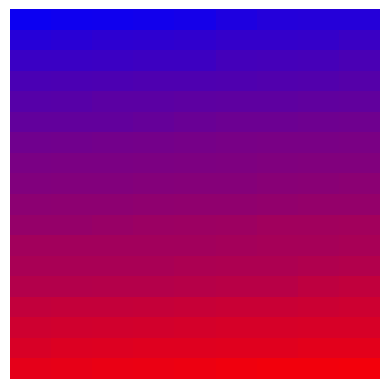

In [13]:
# Visualize the train data loader to see the transformed tensors
train_batch_images, train_batch_labels = next(iter(train_loader))

# Use first image in the batch
first_image_in_train_batch = train_batch_images[0]
image_to_plot = first_image_in_train_batch.permute(1, 2, 0).numpy().astype('uint8')
first_label_in_train_batch = train_batch_labels[0]

# Visualize the tensor as an image 
plt.imshow(image_to_plot)
#plt.title(f"Label: {int_to_label[first_label_in_train_batch.item()]}")
plt.axis('off')

(np.float64(-0.5), np.float64(17.5), np.float64(17.5), np.float64(-0.5))

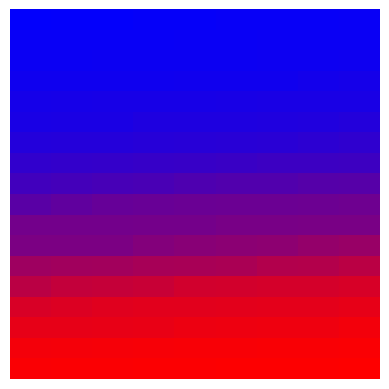

In [14]:
# Visualize the train data loader to see the transformed tensors
val_batch_images, val_batch_labels = next(iter(val_loader))

# Use first image in the batch
first_image_in_val_batch = val_batch_images[0]
image_to_plot = first_image_in_val_batch.permute(1, 2, 0).numpy().astype('uint8')
first_label_in_val_batch = val_batch_labels[0]

# Visualize the tensor as an image
plt.imshow(image_to_plot)
#plt.title(f"Label: {int_to_label[first_label_in_val_batch.item()]}")
plt.axis('off')

### Define model

In [15]:
class PixelPreservingNet(nn.Module):
    def __init__(self, in_channels=3):
        super(PixelPreservingNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Shape is reduced by half

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )

        # Fully connected layers
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling layer
        self.fc1 = nn.Sequential(
            nn.Linear(256, 512), #256->512
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256), #512->256
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        # Output layer
        self.output = nn.Linear(256, 4) #256->4
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.output(x)
        return x

model = PixelPreservingNet(in_channels=3).to(device)

### Define train loop

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler=None):
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X, y in dataloader:
        X = X.to(torch.float32).to(device)
        y = y.to(torch.long).to(device)

        optimizer.zero_grad()

        outputs = model(X)
        loss = loss_fn(outputs, y)

        # Confidence penalty
        softmax_probs = F.softmax(outputs, dim=1)
        entropy = -torch.sum(softmax_probs * torch.log(softmax_probs + 1e-10), dim=1)
        penalty = torch.mean(entropy)
        total_loss_with_penalty = loss - 0.15 * penalty

        total_loss_with_penalty.backward()
        optimizer.step()

        # Scheduler step (per batch)
        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y).sum().item()
        total_train += y.size(0)

    avg_training_loss = running_loss / len(dataloader)
    training_accuracy = correct_train / total_train

    return avg_training_loss, training_accuracy

### Define test loop

In [17]:
def test_loop(dataloader, model, loss_fn):
    
    model.eval()  # Set the model to evaluation mode

    test_loss = 0.0
    correct = 0
    total = 0

    y_pred = []
    y_true = []
    
    with torch.no_grad():  # Disable gradient calculation
        for X, y in dataloader:
            
            # Prepare data
            X = X.to(torch.float32).to(device)
            y = y.to(torch.long).to(device)

            # Forward pass: predict classes
            outputs = model(X)
            
            # Compute the loss
            test_loss += loss_fn(outputs, y).item()

            # Optional: temperature scaling
            #outputs = outputs / 2.0

            # Optional: Class-Prior Logit Biasing (Bayesian approach)
            # class_counts = [2401, 410, 1554, 1112]
            # total = sum(class_counts)
            # class_priors = [c / total for c in class_counts]
            # logit_bias = -torch.log(torch.tensor(class_priors, device=outputs.device))

            #bias = torch.tensor([0.01, 0.25, 0.15, 0.18], device=outputs.device)
            #outputs = outputs + bias
            
            # Apply softmax and get prediction
            probs = F.softmax(outputs, dim=1)
            confidences, predicted = probs.max(dim=1)
            #print(np.bincount(predicted.cpu().numpy(), minlength=4)) ### new
            #print(recall_score(y_true, y_pred, average=None)) ### new

            # Store predictions and true labels
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y.cpu().numpy())

            # Count correct predictions
            correct += (predicted == y).sum().item() 

            # Count total predictions
            total += y.size(0) 

    # Calculate precision and recall for each class
    precision = precision_score(y_true, y_pred, average=None, zero_division=0.0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0.0)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    mcc = matthews_corrcoef(y_true, y_pred)

    avg_test_loss = test_loss / len(dataloader)
    test_accuracy = correct / total
        
    return avg_test_loss, test_accuracy, precision, recall, macro_f1, mcc

### Focal loss

In [18]:
# Focal loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        :param gamma: focusing parameter (default=2.0)
        :param alpha: balance parameter, it can be a float or a tensor (default=None)
        :param reduction: specify the reduction to apply to the output: 'none' | 'mean' | 'sum' (default='mean')
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute cross-entropy loss
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt is the probability of the true class
        
        # Compute the focal loss
        F_loss = (1 - pt) ** self.gamma * BCE_loss
        
        # Apply class weighting (alpha) if provided
        if self.alpha is not None:
            alpha = self.alpha[targets]
            F_loss = alpha * F_loss
        
        # Apply the specified reduction
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

### Training and validation

In [19]:
set_seed(Seed)

# Compute class weights
def compute_class_weights(class_counts): # inverse square root frequency for mild imbalance
    class_weights = 1.0 / torch.sqrt(torch.tensor(class_counts, dtype=torch.float))
    return class_weights / class_weights.sum()

# Given class counts
#class_counts = [2401, 410, 1554, 1112]
#LossWeights = compute_class_weights(class_counts)
LossWeights = torch.tensor([0.16, 0.39, 0.20, 0.24], dtype=torch.float32) # manually set weights
LossWeights = LossWeights.to(device)

# Define the loss function, optimizer and scheduler
criterion = FocalLoss(alpha=LossWeights, gamma=2.0, reduction='mean')  # Focal loss for imbalanced classification
optimizer = optim.AdamW(model.parameters(), lr=Learner_rate, weight_decay=Weight_Decay)  # AdamW optimizer with weight decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,        # reduce LR by half
    patience=10,       # fewer stagnant epochs before reducing
    threshold=1e-4,    # stricter improvement requirement
    cooldown=2,        # wait a bit after LR drop before checking again
    min_lr=1e-7,       # don’t shrink forever
    verbose=True
)

# Set up performance dataframe to record loss, accuracy, precision and recall of each epoch
LossAccDF = pd.DataFrame(index=range(epochs),columns=['Epoch','TrainLoss','ValLoss','TrainAcc','ValAcc'])
PrecisionRecallDF = pd.DataFrame(columns=['Epoch','Class','Precision','Recall', 'Macro F1','MCC'])

# Evaluate the model before training
avg_train_loss, train_accuracy, _, _, macro_f1, mcc = test_loop(train_loader, model, criterion) # compute training performance
avg_val_loss, val_accuracy, precision, recall, macro_f1, mcc = test_loop(val_loader, model, criterion) # compute validation performance

# Print initial performance
print(f"Before Training: "
      f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}",
      f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}",
      f"Macro F1: {macro_f1:.4f}, Matthews Correlation Coefficient: {mcc:.4f}")

# Record the metric in the dataframe
LossAccDF.loc[0,:]=[0,avg_train_loss,avg_val_loss,train_accuracy,val_accuracy]
index=0
for i in range(4):
    PrecisionRecallDF.loc[index]=[0, i, precision[i], recall[i], macro_f1, mcc]
    index += 1

# Training loop
for epoch in range(epochs):

    # Training phase
    avg_train_loss, train_accuracy = train_loop(train_loader, model, criterion, optimizer)
    
    # Validation phase
    avg_val_loss, val_accuracy, precision, recall, macro_f1, mcc = test_loop(val_loader, model, criterion)
    
    # Print epoch loss and accuracy
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}",
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}",
          f"Macro F1: {macro_f1:.4f}, Matthews Correlation Coefficient: {mcc:.4f}")
          

    # Record the metric in the dataframe
    LossAccDF.loc[epoch+1,:]=[epoch+1,avg_train_loss,avg_val_loss,train_accuracy,val_accuracy]
    for i in range(4):
        PrecisionRecallDF.loc[index]=[epoch+1, i, precision[i], recall[i], macro_f1, mcc]
        index += 1

# Save the model
model_path = os.path.join(model_folder_path, f"{Set}_NN_model.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

/opt/conda/envs/pytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Before Training: Training Loss: 0.1675, Training Accuracy: 0.2315 Validation Loss: 0.1678, Validation Accuracy: 0.2327 Macro F1: 0.0944, Matthews Correlation Coefficient: 0.0000
Epoch [1/500], Training Loss: 0.1661, Training Accuracy: 0.2988 Validation Loss: 0.1661, Validation Accuracy: 0.3639 Macro F1: 0.2377, Matthews Correlation Coefficient: 0.0276
Epoch [2/500], Training Loss: 0.1636, Training Accuracy: 0.3386 Validation Loss: 0.1632, Validation Accuracy: 0.3193 Macro F1: 0.2290, Matthews Correlation Coefficient: 0.0847
Epoch [3/500], Training Loss: 0.1633, Training Accuracy: 0.3198 Validation Loss: 0.1625, Validation Accuracy: 0.3267 Macro F1: 0.2220, Matthews Correlation Coefficient: 0.1102
Epoch [4/500], Training Loss: 0.1627, Training Accuracy: 0.3228 Validation Loss: 0.1625, Validation Accuracy: 0.3069 Macro F1: 0.2261, Matthews Correlation Coefficient: 0.0647
Epoch [5/500], Training Loss: 0.1618, Training Accuracy: 0.3438 Validation Loss: 0.1625, Validation Accuracy: 0.3069 M

### Caculating metrics helper function

In [20]:
# Function to calculate the precision and recall
def calculate_metrics(dataloader, model):
    y_pred = []
    y_true = []
    
    model.eval()
    with torch.no_grad():
        
        # iterate over validation data
        for X, y in dataloader:
            
            X = X.to(torch.float32)
            X = X.to(device)
            output = model(X)  # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)  # Save Prediction

            labels = y.cpu().numpy()
            y_true.extend(labels)  # Save Truth

    # Calculate confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Calculate precision and recall for each class
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    mcc = matthews_corrcoef(y_true, y_pred)

    return cf_matrix, precision, recall, macro_f1, mcc

### Confusion matrix

In [21]:
# make a function that visualize 5 confusion matrices from 5 data loaders, and stack them into one figure, 3 by 2
def plot_confusion_matrices(cf_matrices, labels, title):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    axes = axes.flatten()
    
    for i, cf_matrix in enumerate(cf_matrices):
        sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=labels, yticklabels=labels, ax=axes[i])
        #axes[i].set_xlabel('Predicted')
        #axes[i].set_ylabel('True')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].set_title(title[i])
    
    # remove the last empty subplot
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    # set an overall x and y label for the entire figure
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the title
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.text(0.5, 0, 'Predicted', ha='center', fontdict={'size': 16})
    fig.text(0, 0.5, 'True', va='center', rotation='vertical', fontdict={'size': 16})

    #fig.xlabel('Predicted')
    #fig.ylabel('True')
    plt.tight_layout()
    plt.show()

### Testing

In [22]:
model_path

'/home/ec2-user/Feb2025/saved_models/mRNA_FC_model.pth'

In [23]:
# Load the model
last_model = PixelPreservingNet(in_channels=3)
last_model.load_state_dict(torch.load(model_path))
last_model.to(device)

/tmp/ipykernel_6825/3050491375.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  last_model.load_state_dict(torch.load(model_path))


PixelPreservingNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [24]:
# Read in the synthetic data
# Mertins 
#   proteome
M_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_PD_synthetic_kde_qttumor.csv'))
M_PD_synthetic.index = M_PD_synthetic.loc[:,'Index']
M_PD_synthetic = M_PD_synthetic.loc[:, M_PD_synthetic.columns!='Index']

#   transcriptome
M_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_MD_synthetic_kde_qttumor.csv'))
M_MD_synthetic.index = M_MD_synthetic.loc[:,'gene_name']
M_MD_synthetic = M_MD_synthetic.loc[:, M_MD_synthetic.columns!='gene_name']

# LCSCC tumor
#   proteome
lung_tumor_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_tumor_PD_synthetic_kde_qttumor.csv'))
lung_tumor_PD_synthetic.index = lung_tumor_PD_synthetic.loc[:,'Gene']
lung_tumor_PD_synthetic = lung_tumor_PD_synthetic.loc[:, lung_tumor_PD_synthetic.columns!='Gene']

#   transcriptome
lung_tumor_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_tumor_MD_synthetic_kde_qttumor.csv'))
lung_tumor_MD_synthetic.index = lung_tumor_MD_synthetic.loc[:,'gene_name']
lung_tumor_MD_synthetic = lung_tumor_MD_synthetic.loc[:, lung_tumor_MD_synthetic.columns!='gene_name']

# LCSCC NAT
#   proteome
lung_nat_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_nat_PD_synthetic_kde_qttumor.csv'))
lung_nat_PD_synthetic.index = lung_nat_PD_synthetic.loc[:,'Gene']
lung_nat_PD_synthetic = lung_nat_PD_synthetic.loc[:, lung_nat_PD_synthetic.columns!='Gene']

#   transcriptome
lung_nat_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_nat_MD_synthetic_kde_qttumor.csv'))
lung_nat_MD_synthetic.index = lung_nat_MD_synthetic.loc[:,'gene_name']
lung_nat_MD_synthetic = lung_nat_MD_synthetic.loc[:, lung_nat_MD_synthetic.columns!='gene_name']

# Brain glioma
#   proteome
glioma_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'glioma_tumor_PD_synthetic_kde_qttumor.csv'))
glioma_PD_synthetic.index = glioma_PD_synthetic.loc[:,'gene_name']
glioma_PD_synthetic = glioma_PD_synthetic.loc[:, glioma_PD_synthetic.columns!='gene_name']

#   transcriptome
glioma_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'glioma_tumor_MD_synthetic_kde_qttumor.csv'))
glioma_MD_synthetic.index = glioma_MD_synthetic.loc[:,'gene_name']
glioma_MD_synthetic = glioma_MD_synthetic.loc[:, glioma_MD_synthetic.columns!='gene_name']

In [25]:
# Breast
# Read in the label
LD_mcf7 = pd.read_csv(Path(label_path+'markers.txt'), sep='\t')
LD_mcf7.index = LD_mcf7.loc[:,'Protein']
LD_mcf7 = LD_mcf7.loc[:,LD_mcf7.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_mcf7.loc[:,'Localization'] != 'Unclassified'
LD_mcf7 = LD_mcf7.loc[NotUnclassInd,:]

# Lung
LD_h322 = pd.read_csv(Path(label_path+'markers.txt'), sep='\t')
LD_h322.index = LD_h322.loc[:,'Protein']
LD_h322 = LD_h322.loc[:,LD_h322.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_h322.loc[:,'Localization'] != 'Unclassified'
LD_h322 = LD_h322.loc[NotUnclassInd,:]

# Lung
LD_u251 = pd.read_csv(Path(label_path+'markers.txt'), sep='\t')
LD_u251.index = LD_u251.loc[:,'Protein']
LD_u251 = LD_u251.loc[:,LD_u251.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_u251.loc[:,'Localization'] != 'Unclassified'
LD_u251 = LD_u251.loc[NotUnclassInd,:]

In [26]:
M_common_indices = list(set(M_PD_synthetic.index).intersection(set(M_MD_synthetic.index).intersection(set(LD_mcf7.index))))
M_LD = LD_mcf7.loc[LD_mcf7.index.isin(M_common_indices)]
M_PD_synthetic = M_PD_synthetic.loc[M_PD_synthetic.index.isin(M_common_indices)]
M_MD_synthetic = M_MD_synthetic.loc[M_MD_synthetic.index.isin(M_common_indices)]

lung_tumor_common_indices = list(set(lung_tumor_PD_synthetic.index).intersection(set(lung_tumor_MD_synthetic.index).intersection(set(LD_h322.index))))
lung_tumor_LD = LD_h322.loc[LD_h322.index.isin(lung_tumor_common_indices)]
lung_tumor_PD_synthetic = lung_tumor_PD_synthetic.loc[lung_tumor_PD_synthetic.index.isin(lung_tumor_common_indices)]
lung_tumor_MD_synthetic = lung_tumor_MD_synthetic.loc[lung_tumor_MD_synthetic.index.isin(lung_tumor_common_indices)]

lung_nat_common_indices = list(set(lung_nat_PD_synthetic.index).intersection(set(lung_nat_MD_synthetic.index).intersection(set(LD_h322.index))))
lung_nat_LD = LD_h322.loc[LD_h322.index.isin(lung_nat_common_indices)]
lung_nat_PD_synthetic = lung_nat_PD_synthetic.loc[lung_nat_PD_synthetic.index.isin(lung_nat_common_indices)]
lung_nat_MD_synthetic = lung_nat_MD_synthetic.loc[lung_nat_MD_synthetic.index.isin(lung_nat_common_indices)]

glioma_common_indices = list(set(glioma_PD_synthetic.index).intersection(set(glioma_MD_synthetic.index).intersection(set(LD_u251.index))))
glioma_LD = LD_u251.loc[LD_u251.index.isin(glioma_common_indices)]
glioma_PD_synthetic = glioma_PD_synthetic.loc[glioma_PD_synthetic.index.isin(glioma_common_indices)]
glioma_MD_synthetic = glioma_MD_synthetic.loc[glioma_MD_synthetic.index.isin(glioma_common_indices)]

# Convert string labels to integers
M_test_labels = [label_to_int[label] for label in M_LD['Localization'].values]
lung_tumor_test_labels = [label_to_int[label] for label in lung_tumor_LD['Localization'].values]
lung_nat_test_labels = [label_to_int[label] for label in lung_nat_LD['Localization'].values]
glioma_test_labels = [label_to_int[label] for label in glioma_LD['Localization'].values]

# Create the test datasets
if Set == 'Protein':
    M_test_dataset = MyDataset(Set, M_PD_synthetic, M_PD_synthetic, M_PD_synthetic.index, M_test_labels)
    lung_tumor_test_dataset = MyDataset(Set, lung_tumor_PD_synthetic, lung_tumor_PD_synthetic, lung_tumor_PD_synthetic.index, lung_tumor_test_labels)
    lung_nat_test_dataset = MyDataset(Set, lung_nat_PD_synthetic, lung_nat_PD_synthetic, lung_nat_PD_synthetic.index, lung_nat_test_labels)
    glioma_test_dataset = MyDataset(Set, glioma_PD_synthetic, glioma_PD_synthetic, glioma_PD_synthetic.index, glioma_test_labels)
elif Set == 'mRNA':
    M_test_dataset = MyDataset(Set, M_MD_synthetic, M_MD_synthetic, M_MD_synthetic.index, M_test_labels)
    lung_tumor_test_dataset = MyDataset(Set, lung_tumor_MD_synthetic, lung_tumor_MD_synthetic, lung_tumor_MD_synthetic.index, lung_tumor_test_labels)
    lung_nat_test_dataset = MyDataset(Set, lung_nat_MD_synthetic, lung_nat_MD_synthetic, lung_nat_MD_synthetic.index, lung_nat_test_labels)
    glioma_test_dataset = MyDataset(Set, glioma_MD_synthetic, glioma_MD_synthetic, glioma_MD_synthetic.index, glioma_test_labels)
elif Set == 'Protein + mRNA':
    M_test_dataset = MyDataset(Set, M_PD_synthetic, M_MD_synthetic, M_PD_synthetic.index, M_test_labels)
    lung_tumor_test_dataset = MyDataset(Set, lung_tumor_PD_synthetic, lung_tumor_MD_synthetic, lung_tumor_PD_synthetic.index, lung_tumor_test_labels)
    lung_nat_test_dataset = MyDataset(Set, lung_nat_PD_synthetic, lung_nat_MD_synthetic, lung_nat_PD_synthetic.index, lung_nat_test_labels)
    glioma_test_dataset = MyDataset(Set, glioma_PD_synthetic, glioma_MD_synthetic, glioma_PD_synthetic.index, glioma_test_labels)
else:
    raise ValueError("Invalid dataset selection. Choose 'Protein', 'mRNA', 'Protein + mRNA', 'Protein + mRNA Stack'.")

# Create the test data loaders
set_seed(Seed)
M_test_loader = DataLoader(M_test_dataset, batch_size=Batch_size, shuffle=False)
lung_tumor_test_loader = DataLoader(lung_tumor_test_dataset, batch_size=Batch_size, shuffle=False)
lung_nat_test_loader = DataLoader(lung_nat_test_dataset, batch_size=Batch_size, shuffle=False)
glioma_test_loader = DataLoader(glioma_test_dataset, batch_size=Batch_size, shuffle=False)


## Metrics

### Fig 1: training and validation loss

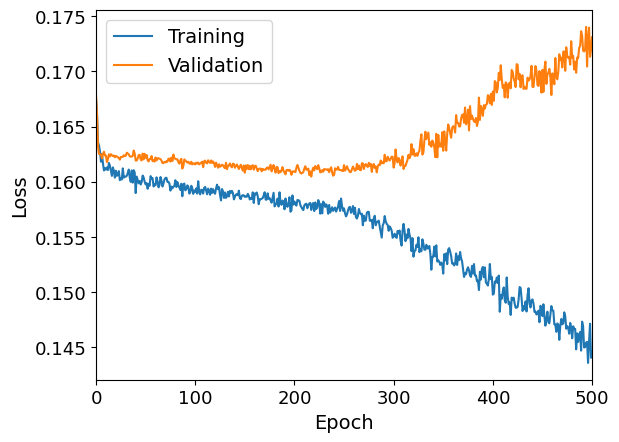

In [27]:
# Graph loss for training and validation
figure1 = plt.gcf()
plt.plot(LossAccDF['Epoch'], LossAccDF['TrainLoss'])
plt.plot(LossAccDF['Epoch'], LossAccDF['ValLoss'])
plt.xlim([0,epochs])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.legend(['Training', 'Validation'], fontsize=14)

# Save figure into figure bank
figure1.savefig(Path(fig_bank_path+Set+'_Loss.png'), dpi=300)

### Fig 2: training and validation accuracy

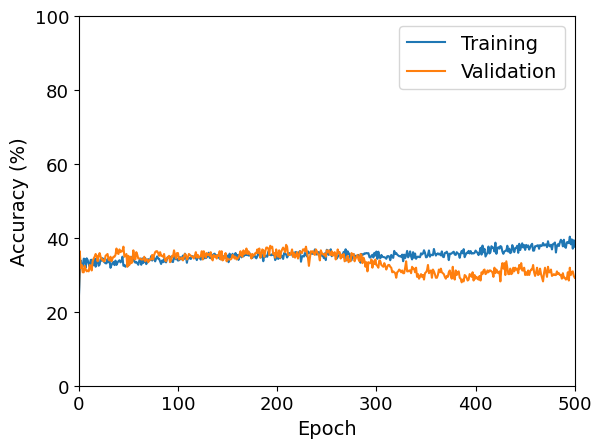

In [28]:
# Graph accuracy for training and validation
figure2 = plt.gcf()
plt.plot(LossAccDF['Epoch'], (LossAccDF['TrainAcc'])*100)
plt.plot(LossAccDF['Epoch'], (LossAccDF['ValAcc'])*100)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.xlim([0,epochs])
plt.ylim([0,100])
plt.legend(['Training', 'Validation'], fontsize=14)

# Save figure into figure bank
figure2.savefig(Path(fig_bank_path+Set+'_Acc.png'), dpi=300)

### Fig 3: confusion matrices

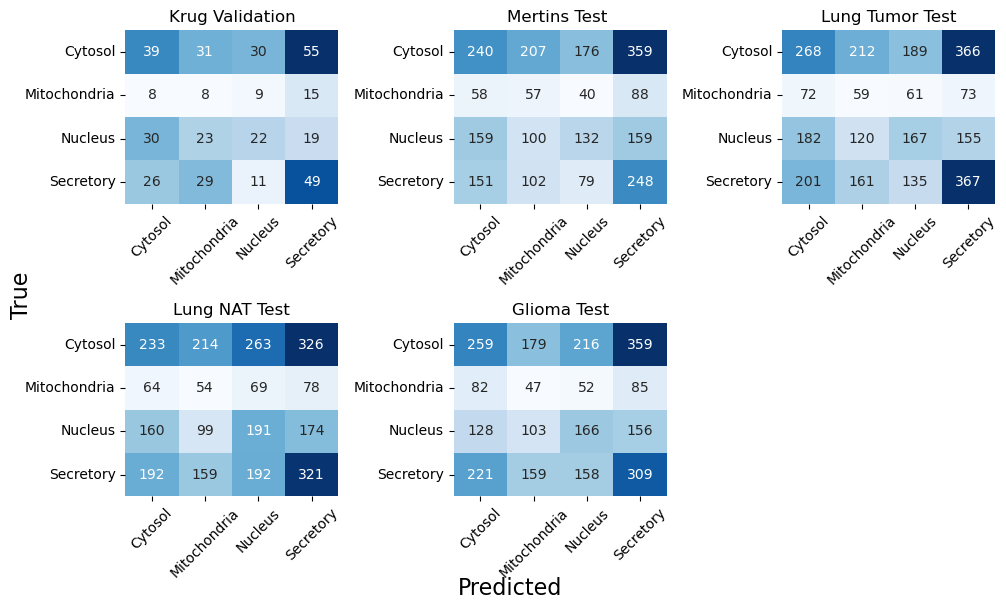

<Figure size 640x480 with 0 Axes>

In [29]:
# Set seed
set_seed(Seed)

# Get the confusion matrix and precision and recall for the validation loader and all test loaders
cf_matrix_val, precision_val, recall_val, macro_f1_val, mcc_val = calculate_metrics(val_loader, last_model)
cf_matrix_M, precision_M, recall_M, macro_f1_M, mcc_M = calculate_metrics(M_test_loader, last_model)
cf_matrix_lung_tumor, precision_lung_tumor, recall_lung_tumor, macro_f1_lung_tumor, mcc_lung_tumor = calculate_metrics(lung_tumor_test_loader, last_model)
cf_matrix_lung_nat, precision_lung_nat, recall_lung_nat, macro_f1_lung_nat, mcc_lung_nat = calculate_metrics(lung_nat_test_loader, last_model)
cf_matrix_glioma, precision_glioma, recall_glioma, macro_f1_glioma, mcc_glioma = calculate_metrics(glioma_test_loader, last_model)

# Put them into a list
cf_matrices = [cf_matrix_val, cf_matrix_M, cf_matrix_lung_tumor, cf_matrix_lung_nat, cf_matrix_glioma]
titles = ['Krug Validation', 'Mertins Test ', 'Lung Tumor Test', 'Lung NAT Test', 'Glioma Test']

# Plot the confusion matrices
plot_confusion_matrices(cf_matrices, labels=int_to_label.values(), title=titles)

# Save figure into figure bank
figure3 = plt.gcf()
figure3.savefig(Path(fig_bank_path+Set+'_Confusion_Matrices.png'), dpi=300)

### Fig 4: macro F1 and MCC

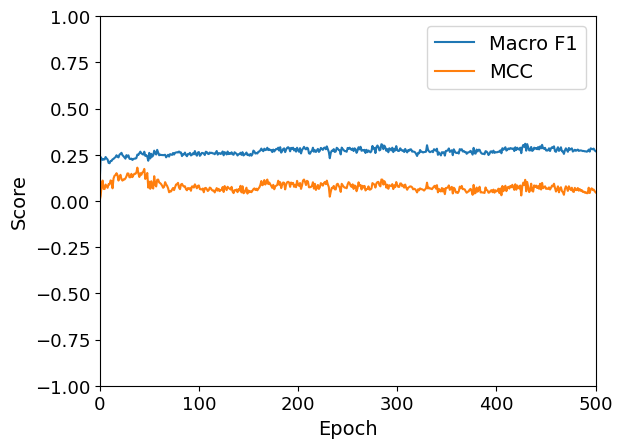

In [30]:
# Plot macro F1 and MCC score in PrecisionRecallDF vs epoch
figure4 = plt.gcf()
plt.plot(PrecisionRecallDF['Epoch'], PrecisionRecallDF['Macro F1'])
plt.plot(PrecisionRecallDF['Epoch'], PrecisionRecallDF['MCC'])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.xlim([0,epochs])
plt.ylim([-1,1])
plt.legend(['Macro F1', 'MCC'], fontsize=14)
# Save figure into figure bank
figure4.savefig(Path(fig_bank_path+Set+'_MacroF1_MCC.png'), dpi=300)


### Fig 5: Precision and recall of validation and testing

/tmp/ipykernel_6825/2494792526.py:50: RuntimeWarning: divide by zero encountered in divide
  y_right = f1_score * x_right / (2 * x_right - f1_score)


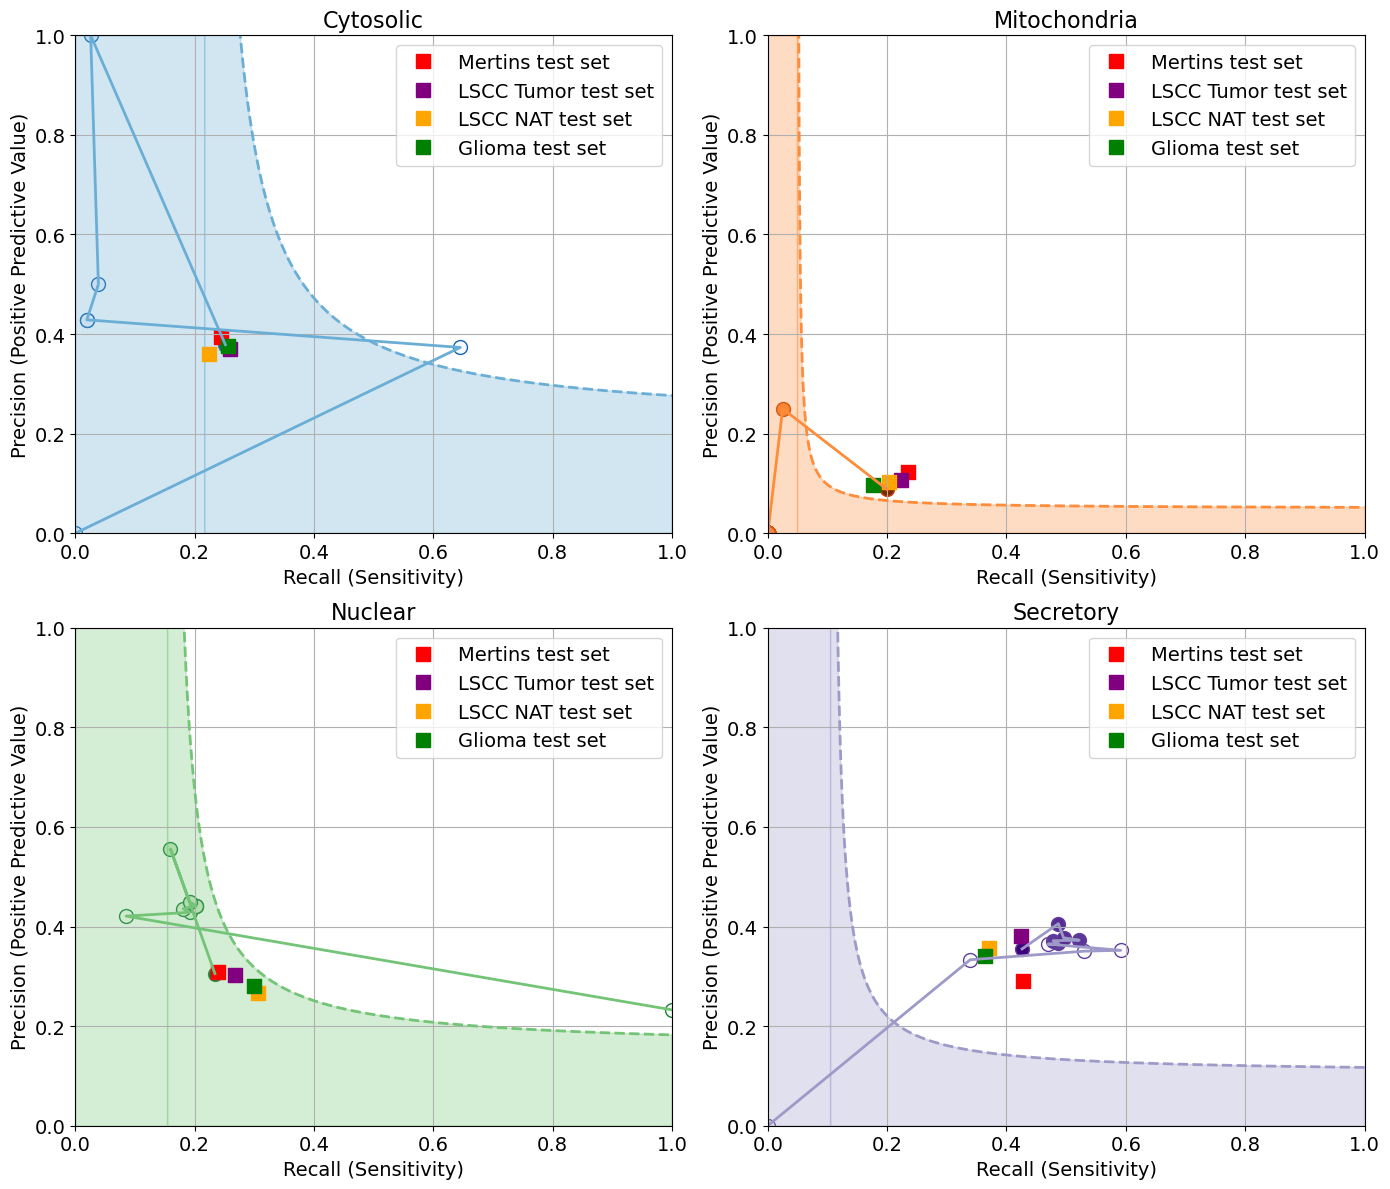

<Figure size 640x480 with 0 Axes>

In [31]:
set_seed(Seed)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()
compartment_class = ['Cytosolic', 'Mitochondria', 'Nuclear', 'Secretory']
colormaps = [cm.Blues, cm.Oranges, cm.Greens, cm.Purples]

# Function to filter improvement epochs using precision as the guide
def filter_improvement_epochs(df):
    improved_epochs = []
    for class_label in df['Class'].unique():
        class_df = df[df['Class'] == class_label].copy()
        class_df = class_df.sort_values(by='Epoch')
        max_precision = float('-inf')
        
        for _, row in class_df.iterrows():
            if row['Precision'] >= max_precision:
                max_precision = row['Precision']
                improved_epochs.append(row)
    
    # Ensure starting (0) and ending (last) epochs are included
    start_epoch = df[df['Epoch'] == 0]
    last_epoch = df[df['Epoch'] == df['Epoch'].max()]
    
    return pd.concat([start_epoch, pd.DataFrame(improved_epochs), last_epoch]).drop_duplicates()

# Get improvement epochs based on precision
improved_epochs_df = filter_improvement_epochs(PrecisionRecallDF)

for i, f1_score in enumerate(np.array([0.43314056, 0.09879518, 0.30857335, 0.20966921])):
    # Select the subplot
    ax = axes[i]

    # Filter the metrics for the current class
    class_metrics = improved_epochs_df[improved_epochs_df['Class'] == i]
    # Normalize epoch for color mapping
    norm = plt.Normalize(class_metrics['Epoch'].min(), class_metrics['Epoch'].max())

    # Scatter plot with gradient color based on epoch
    for idx, row in class_metrics.iterrows():
        color = colormaps[i](norm(row['Epoch']))
        edge_color = colormaps[i](0.8)
        ax.scatter(row['Recall'], row['Precision'], s=100, color=color, edgecolors=edge_color, linewidths=1)

    # Connect the dots with colored lines
    ax.plot(class_metrics['Recall'], class_metrics['Precision'], color=colormaps[i](0.5), linewidth=2)

    # Plot the F1 score curve
    x_left = np.linspace(0, (f1_score / 2), 10000)
    x_right = np.linspace((f1_score / 2), 1, 10000)
    y_right = f1_score * x_right / (2 * x_right - f1_score)
    ax.plot(x_right, y_right, color=colormaps[i](0.5), linestyle='--', linewidth=2)
    # Fill the area on the left of the curve
    ax.fill_between(x_left, 0, 1, color=colormaps[i](0.5), alpha=0.3)
    ax.fill_between(x_right, 0, y_right, color=colormaps[i](0.5), alpha=0.3)

    # Add in a scatter dot to label the precision and recall of testing set
    ax.scatter(recall_M[i], precision_M[i], s=100, color='red', edgecolors='red', linewidths=1, marker='s')
    ax.scatter(recall_lung_tumor[i], precision_lung_tumor[i], s=100, color='purple', edgecolors='purple', linewidths=1, marker='s')
    ax.scatter(recall_lung_nat[i], precision_lung_nat[i], s=100, color='orange', edgecolors='orange', linewidths=1, marker='s')
    ax.scatter(recall_glioma[i], precision_glioma[i], s=100, color='green', edgecolors='green', linewidths=1, marker='s')

    # Aesthetics
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(compartment_class[i], fontsize=16)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Recall (Sensitivity)', fontsize=14)
    ax.set_ylabel('Precision (Positive Predictive Value)', fontsize=14)
    ax.grid(True)

    # Create custom legend handles
    mertins_handle = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=10, label='Mertins test set')
    lung_tumor_handle = mlines.Line2D([], [], color='purple', marker='s', linestyle='None', markersize=10, label='LSCC Tumor test set')
    lung_nat_handle = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, label='LSCC NAT test set')
    glioma_handle = mlines.Line2D([], [], color='green', marker='s', linestyle='None', markersize=10, label='Glioma test set')

    # Add the legend to the plot
    ax.legend(handles=[mertins_handle, lung_tumor_handle, lung_nat_handle, glioma_handle], loc='upper right', fontsize=14)

plt.tight_layout()
plt.show()

# Save figure into figure bank
figure5 = plt.gcf()
figure5.savefig(Path(fig_bank_path+Set+'_Precision_Recall_F1curve.png'), dpi=300)


In [32]:
# export dataframes
LossAccDF.to_excel(Path(fig_bank_path + Set+ f'LossAccDF.xlsx'), index=False)
PrecisionRecallDF.to_excel(Path(fig_bank_path + Set+ f'PrecisionRecallDF.xlsx'), index=False)